In [59]:
f = open("untitled.txt")

In [60]:
x =f.readlines()

In [62]:
#q.split()

In [63]:
trains = []
vals = []
train_losses = []
val_losses = []
c = 0
for i in x:
    q = i.strip()
    if not q.startswith("Ep"):
        #print(q.split())
        train_losses.append(float(q.split()[7]))
        val_losses.append(float(q.split()[-4]))
        train = q.split()[10]
        val = q.split()[-1]
        trains.append(float(train))
        vals.append(float(val))
    


IndexError: list index out of range

In [64]:
val_losses

[0.9124,
 0.8518,
 0.8086,
 0.7707,
 0.7851,
 0.7664,
 0.7773,
 0.7807,
 0.8093,
 0.8617]

In [65]:
import matplotlib.pyplot as plt

In [66]:
import numpy as np

In [67]:
trains

[0.5143,
 0.6523,
 0.6914,
 0.7203,
 0.7385,
 0.7534,
 0.7668,
 0.7779,
 0.7883,
 0.7973]

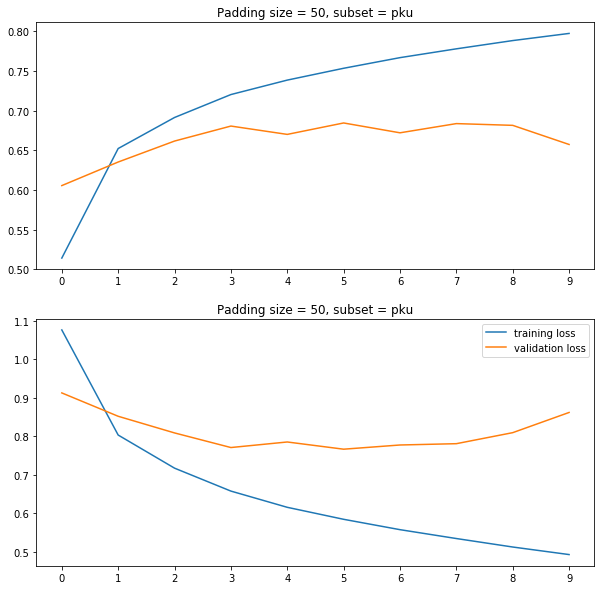

In [70]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(trains, label = 'training accuracy')
plt.plot(vals, label = 'validation accuracy')
plt.xticks(np.arange(0,10))
plt.title("Padding size = 50, subset = pku")
#plt.yticks(np.arange(0.1,1.1,0.1))
#plt.legend()

plt.subplot(2,1,2)
plt.plot(train_losses, label = 'training loss')
plt.plot(val_losses, label = 'validation loss')
plt.xticks(np.arange(0,10))
plt.title("Padding size = 50, subset = pku")
#plt.yticks(np.arange(0.1,1.1,0.1))
plt.legend()
plt.show()

In [69]:
len(np.arange(0.1,1.1,0.1))

10

ValueError: x and y must have same first dimension, but have shapes (10,) and (0,)

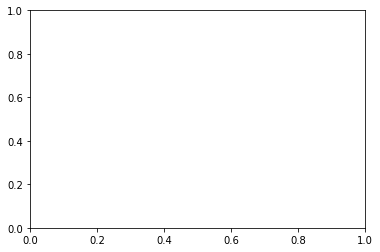

In [35]:
plt.plot(x1, vals, 'o')

vals

In [ ]:
plt.plot([0, 1,2,3,4,5,6,7,8,9], [int(i*100) for i in vals])

In [ ]:
[int(i) for i in vals]

In [ ]:
plt.plot(x,y)